# Ingest and load local refcat demo using DELVE_DR1

<br>Owner: **Peter Ferguson** ([@psferguson](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@psferguson))
<br>Last Verified to Run: **2022-02-18**
<br>Verified Stack Release: **w_2021_49**

### Learning Objectives

This notebook demonstrates how to: <br>
1. Create an LSST format reference catalog from existing acii or fits reference catalog
2. Create an empty gen3 repo
3. Ingest the LSST format refcat into newly created repo
4. Load reference catalog in butler

### Set Up 
You can find the Stack version by using `eups list -s` on the terminal command line.

In [1]:
# Site, host, and stack version
! echo $EXTERNAL_INSTANCE_URL
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

https://lsst-lsp-stable.ncsa.illinois.edu
nb-pferguso
lsst_distrib          22.0.1-3-g7ae64ea+517d8e5442 	current w_2021_49 setup


In [2]:
import subprocess
import numpy as np
import pylab as plt
import lsst.geom
import lsst.daf.butler  as dafButler

### Create a gen3 reference catalog

For this example we will create a refcat from a DELVE (DEcam Local Volume Exploration survey [Website](https://delve-survey.github.io/)) DR1 healpixel located on NCSA, and import it into a gen3 repo. 

Following the developer instructions [piplines refcat documentation](https://pipelines.lsst.io/v/daily/modules/lsst.meas.algorithms/creating-a-reference-catalog.html)

The first step is to use the `ConvertReferenceCatalogTask` along with a config we create for the conversion to create a catalog in LSST format. 

In [3]:
# setting names
refcatDir='custom_refcat_demo'
configFile="ingestConfigOverride.cfg"
inputFile="/project/shared/data/delve_dr1/cat/cat_hpx_07798.fits"

In [4]:
! mkdir {refcatDir}
#! echo "lsst.obs.lsst.LsstCamMapper" > {refcatDir}/_mapper

Below is the set of configs used in creating this refcat
 1. Since the refcat is in Fits format we retarget the file reader
 2. It is required to give a name to this refcat, in this case delve_dr1
 3. We also need to specify ra, dec, mag, and mag_error columns
 4. Finally we can give the config a list of extra columns to include in the refcat (e.g. star/gal classifier)
 
for this tutorial we will change the HTM depth to 4 to improve runtime but an HTM depth of 7 is default

In [5]:
%%writefile {configFile}
from lsst.meas.algorithms.readFitsCatalogTask import ReadFitsCatalogTask

# Default is ReadTextCatalogTask
config.file_reader.retarget(ReadFitsCatalogTask)

# String to pass to the butler to retrieve persisted files.
config.dataset_config.ref_dataset_name='delve_dr1'


config.dataset_config.indexer.name='HTM'

# Depth of the HTM tree to make.  Default is depth=7 which gives ~ 0.3 sq. deg. per trixel.
# for this tutorial we will change the HTM depth to 3 to improve runtime 
config.dataset_config.indexer['HTM'].depth=4

# Number of python processes to use when ingesting.
config.n_processes=5

# Name of RA column
config.ra_name='RA'

# Name of Dec column
config.dec_name='DEC'

# Name of column to use as an identifier (optional).
config.id_name='QUICK_OBJECT_ID'

# The values in the reference catalog are assumed to be in AB magnitudes. List of column names to use for
# photometric information.  At least one entry is required.
config.mag_column_list=['MAG_PSF_G', 'MAG_PSF_R','MAG_PSF_I', 'MAG_PSF_Z']

# A map of magnitude column name (key) to magnitude error column (value).
config.mag_err_column_map={'MAG_PSF_G':'MAGERR_PSF_G', 'MAG_PSF_R':'MAGERR_PSF_R','MAG_PSF_I':'MAGERR_PSF_I', 'MAG_PSF_Z':'MAGERR_PSF_Z'}

# Names of extra columns to include 
config.extra_col_names=['SPREAD_MODEL_G','SPREAD_MODEL_R','SPREAD_MODEL_I','SPREAD_MODEL_Z',
                        'SPREADERR_MODEL_G', 'SPREADERR_MODEL_R', 'SPREADERR_MODEL_I', 'SPREADERR_MODEL_Z',
                        'EXTINCTION_G', 'EXTINCTION_R', 'EXTINCTION_I', 'EXTINCTION_Z']


Overwriting ingestConfigOverride.cfg


### Convert Files to LSST format
We then use the `convertReferenceCatalog` command line tool to ingest the catalog, this takes a bit of time to run. 

In [6]:
! convertReferenceCatalog {refcatDir} {configFile} {inputFile}

lsst.ConvertReferenceCatalogTask INFO: Creating 2048 file locks.
lsst.ConvertReferenceCatalogTask INFO: File locks created.
lsst.ConvertReferenceCatalogTask INFO: Completed 1 / 1 files: 100 % complete 
Completed refcat conversion. Ingest the resulting files with the following commands, substituting the path to your butler repo for REPO:
    butler register-dataset-type REPO delve_dr1 SimpleCatalog htm7
    butler ingest-files -t direct REPO gaia_dr2 refcats custom_refcat_demo/filename_to_htm.ecsv


example output:

    lsst.ConvertReferenceCatalogTask INFO: Creating 131072 file locks.
    lsst.ConvertReferenceCatalogTask INFO: File locks created.
    lsst.ConvertReferenceCatalogTask INFO: Completed 1 / 1 files: 100 % complete 
    Completed refcat conversion. Ingest the resulting files with the following commands, substituting the path to your butler repo for REPO:
        butler register-dataset-type REPO delve_dr1 SimpleCatalog htm7
        butler ingest-files -t direct REPO gaia_dr2 refcats custom_refcat_demo/filename_to_htm.ecsv

### create a gen3 repo and load catalog into it
We now have a LSST format refcat, for this demo we will create a new gen3 repo to ingest the refcat into. 

The creation of an empty repo needs a `butler.yaml` file.

#### **This file should be placed in the refcatDir**  (e.g `./custom_refcat_demo/butler.yaml`).

example file is in the next cell. 

Now we can run the `butler create` command line task this will create a new repo.

In [9]:
repoName="test_repo_gen3"
! mkdir {refcatDir}/{repoName}
! touch {refcatDir}/{repoName}/test.sqlite3

mkdir: cannot create directory ‘custom_refcat_demo/test_repo_gen3’: File exists
lsst.daf.butler.cli.utils ERROR: Caught an exception, details are in traceback:
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/daf_butler/22.0.1-110-g1427568b+500492d978/python/lsst/daf/butler/cli/cmd/commands.py", line 121, in create
    script.createRepo(*args, **kwargs)
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/daf_butler/22.0.1-110-g1427568b+500492d978/python/lsst/daf/butler/script/createRepo.py", line 48, in createRepo
    config = Config(seed_config) if seed_config is not None else None
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/daf_butler/22.0.1-110-g1427568b+500492d978/python/lsst/daf/butler/core/config.py", line 258, in __init__
    self.__initFromUri(other)
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/daf_butler/22.0.1-110-g1427568b+500492d97

In [10]:
!butler create {refcatDir}/{repoName} --seed-config {refcatDir}/butler.yaml --override

Now that we have an empty gen3 repo we can ingest the catalot into it with the following commands. 

    butler register-dataset-type REPO RefcatName SimpleCatalog htm3
    butler ingest-files -t direct REPO RefcatName collectionName filename_to_htm.ecsv
note the collection name must be a RUN not CHAIN type collection.

Also note htm option must match with ingestion config. 

In [11]:
!butler register-dataset-type {refcatDir}/{repoName} delve_dr1 SimpleCatalog htm4
!butler ingest-files -t direct {refcatDir}/{repoName} delve_dr1 refcats {refcatDir}/filename_to_htm.ecsv

Dataset type successfully registered.
lsst.daf.butler.script.ingest_files INFO: Ingesting 2 dataset ref(s) from 2 file(s)


### Loading the new refcat
Then we can load this new repo, and check the "refcats/gen2" collection to see what it contains. 

In [20]:
butler = dafButler.Butler(refcatDir+"/"+repoName, writeable=True)
registry = butler.registry

In [21]:
[i for i in list(registry.queryCollections())]

['refcats']

In [22]:
registry.getCollectionSummary('refcats').datasetTypes.names

dict_keys(['delve_dr1'])

We can set a docstring for this refcat collection

In [23]:
registry.setCollectionDocumentation('refcats', "doc for delve dr1 refcat")

No longer need collection to be writeable 

In [24]:
butler = dafButler.Butler(refcatDir+"/"+repoName, writeable=True)
registry = butler.registry

In [26]:
registry.getCollectionDocumentation('refcats')

'doc for delve dr1 refcat'

In [27]:
refDataset="delve_dr1"
refcatRefs = list(registry.queryDatasets(datasetType=refDataset,
                                          collections=["refcats"]).expanded())
refDataIds=[_.dataId for _ in refcatRefs]
refCatsDef = [butler.getDeferred(refDataset, __, collections=['refcats']) for __ in refDataIds]

In [28]:
refCats=[butler.getDirect(__) for __ in refcatRefs]

Finally we can plot the loaded refcat 

Text(0, 0.5, 'DEC')

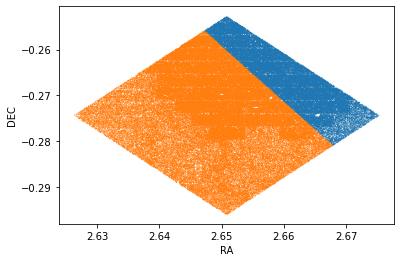

In [29]:
import pylab as plt
fit,ax=plt.subplots()
for refCat in refCats:
    ax.scatter(refCat["coord_ra"], refCat["coord_dec"], label="refcat",s=0.01)
plt.xlabel("RA")
plt.ylabel("DEC")